[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/corazzon/boostcourse-ds-511/blob/master/pima-classification-baseline-01.ipynb)


* 강좌 보기 : https://www.edwith.org/boostcourse-ds-511

<img src="https://upload.wikimedia.org/wikipedia/commons/6/6f/Pima.jpg" width=200>

* [Pima people - Wikipedia](https://en.wikipedia.org/wiki/Pima_people)
* 미국의 피마 인디언에게서 서구화로 인한 당뇨병 발병

## 데이터셋 출처
* [Pima Indians Diabetes Database | Kaggle](https://www.kaggle.com/uciml/pima-indians-diabetes-database)
    * 데이터의 개수가 더 많음
* https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html


### 데이터 구성

* Pregnancies : 임신 횟수
* Glucose : 2시간 동안의 경구 포도당 내성 검사에서 혈장 포도당 농도 
* BloodPressure : 이완기 혈압 (mm Hg)
* SkinThickness : 삼두근 피부 주름 두께 (mm), 체지방을 추정하는데 사용되는 값
* Insulin : 2시간 혈청 인슐린 (mu U / ml)
* BMI : 체질량 지수 (체중kg / 키(m)^2)
* DiabetesPedigreeFunction : 당뇨병 혈통 기능
* Age : 나이
* Outcome : 768개 중에 268개의 결과 클래스 변수(0 또는 1)는 1이고 나머지는 0입니다.
    * 예측해야 할 데이터

## EDA 결과
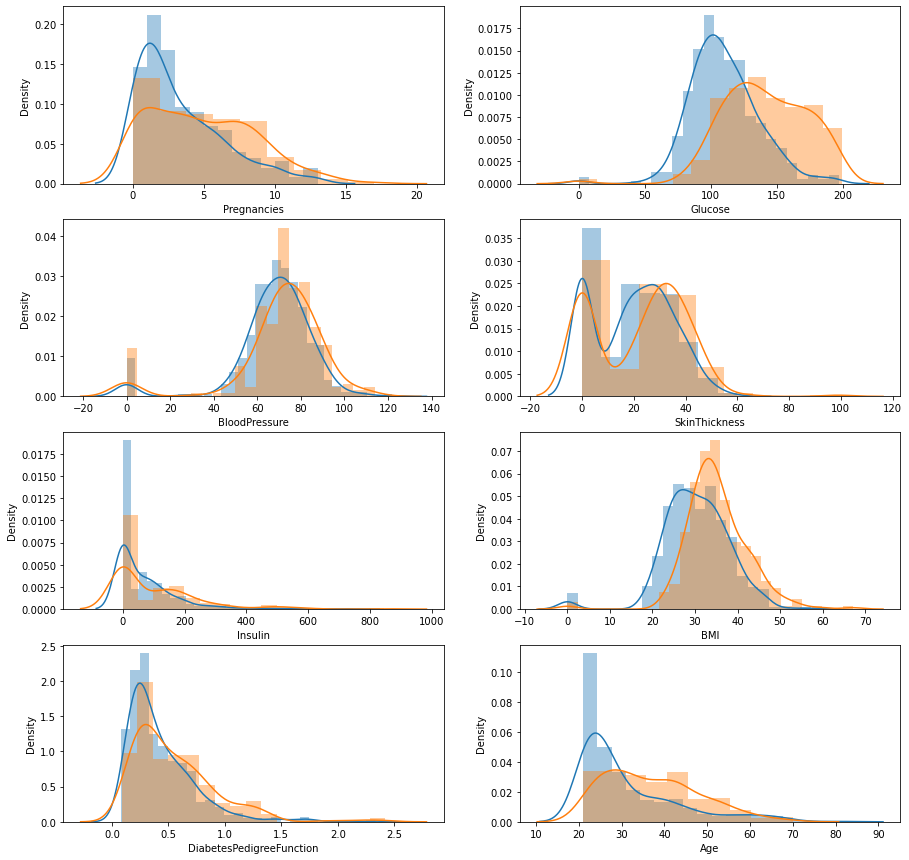

* 조건을 일반화해야 한다.
    * Pregnancies 횟수는 20회에 가까워질수록 수 많지 않기 때문에 일반화하기 어렵다.
    * Age는 30세, 60세를 전후로 당뇨병 발병 여부에 차이가 있다.
    * Insulin은 결측치가 매우 많으며, 값이 왼쪽으로 몰려있다.
    * 수치형 데이터 몇 가지를 범주형으로 만든다.(Pregnancies, Glucose, BMI, Age 등)

## 필요한 라이브러리 로드

In [2]:
# 데이터 분석을 위한 pandas, 수치계산을 위한 numpy
# 시각화를 위한 seaborn, matplotlib.pyplot 을 로드합니다. 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## 데이터셋 로드

In [3]:
df = pd.read_csv("data/diabetes.csv")
df.shape

(768, 9)

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Feature Engineering

### 수치형 변수를 범주형 변수로 만들기
* Pregnancies 값이 6보다 큰 경우와 그렇지 않은 경우로 구분한다.
* Age를 25세 미만, 25세 이상 60세 이하, 60세 초과로 구분한다.

In [5]:
df["Pregnancies_high"] = df["Pregnancies"] > 6
df[["Pregnancies", "Pregnancies_high"]]

,Pregnancies,Pregnancies_high
0,6,False
1,1,False
2,8,True
3,1,False
4,0,False
...,...,...
763,10,True
764,2,False
765,5,False
766,1,False


In [6]:
# One-Hot-Encodng
df["Age_low"] = df["Age"] < 25
df["Age_middle"] = (df["Age"] >= 25) & (df["Age"] <= 60)
df["Age_high"] = df["Age"] > 60
df[["Age", "Age_low", "Age_middle", "Age_high"]]

,Age,Age_low,Age_middle,Age_high
0,50,False,True,False
1,31,False,True,False
2,32,False,True,False
3,21,True,False,False
4,33,False,True,False
...,...,...,...,...
763,63,False,False,True
764,27,False,True,False
765,30,False,True,False
766,47,False,True,False


<AxesSubplot:xlabel='Age_high', ylabel='count'>

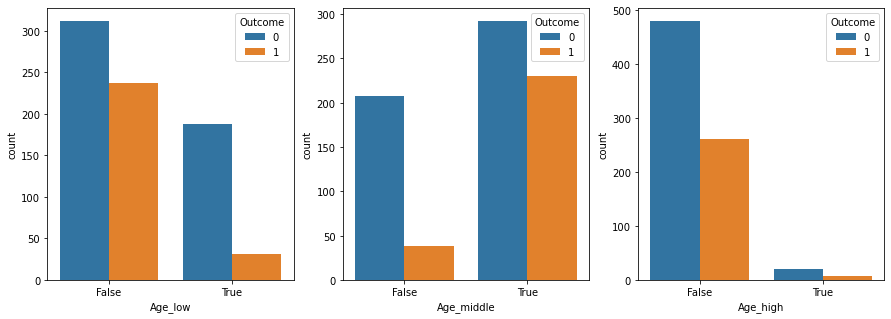

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
sns.countplot(data=df, x="Age_low", hue="Outcome", ax=axes[0])
sns.countplot(data=df, x="Age_middle", hue="Outcome", ax=axes[1])
sns.countplot(data=df, x="Age_high", hue="Outcome", ax=axes[2])

### 결측치 다루기

In [8]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
Pregnancies_high            0
Age_low                     0
Age_middle                  0
Age_high                    0
dtype: int64

In [9]:
# 0의 값을 가질 수 없는 데 가지고 있는 변수들이 있으므로, 0이 결측치라고 추측할 수 있다.
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [10]:
df["Insulin_nan"] = df["Insulin"].replace(0, np.nan)
df[["Insulin", "Insulin_nan"]]

,Insulin,Insulin_nan
0,0,NaN
1,0,NaN
2,0,NaN
3,94,94.0
4,168,168.0
...,...,...
763,180,180.0
764,0,NaN
765,112,112.0
766,0,NaN


In [11]:
df["Insulin_nan"].isnull().sum()

374

In [12]:
df["Insulin_nan"].isnull().mean()

0.4869791666666667

* 결측치 비율이 높은 편이다.

In [13]:
df.groupby(["Outcome"])["Insulin", "Insulin_nan"].agg(["mean", "median"])

C:\Users\S\AppData\Local\Temp/ipykernel_5720/368444390.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(["Outcome"])["Insulin", "Insulin_nan"].agg(["mean", "median"])


Insulin        Insulin_nan       
               mean median        mean median
Outcome                                      
0         68.792000   39.0  130.287879  102.5
1        100.335821    0.0  206.846154  169.5

* Nan 처리를 하기 전과 후의 차이가 꽤 크다.

In [14]:
# 결측치 채우기
df.loc[(df["Outcome"] == 0) & (df["Insulin_nan"].isnull()), "Insulin_nan"] = 102.5
df.loc[(df["Outcome"] == 1) & (df["Insulin_nan"].isnull()), "Insulin_nan"] = 169.5

### 정규분포 만들기

E:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Insulin', ylabel='Density'>

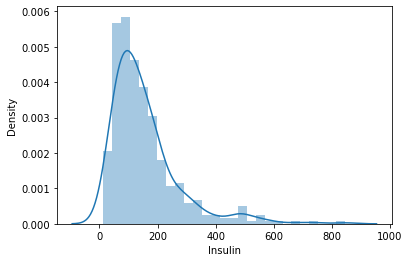

In [15]:
# Insulin이 왼쪽으로 치우치게 분포해있다.
sns.distplot(df.loc[df["Insulin"] > 0, "Insulin"])

E:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Insulin', ylabel='Density'>

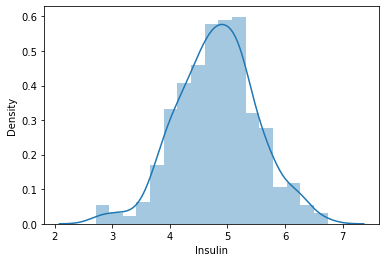

In [16]:
# Insulin을 로그변환해주면 정규분포에 가까워진다.
sns.distplot(np.log(df.loc[df["Insulin"] > 0, "Insulin"]+1))

E:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Insulin_nan', ylabel='Density'>

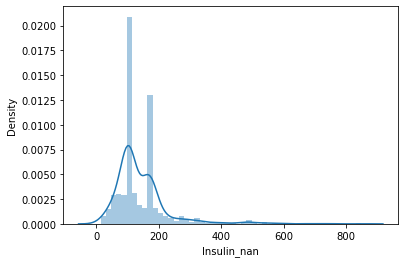

In [17]:
# Insulin_nan은 중앙값으로 채워져 첨도가 높고, 꼬리가 길다.
sns.distplot(df["Insulin_nan"])

E:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Insulin_log', ylabel='Density'>

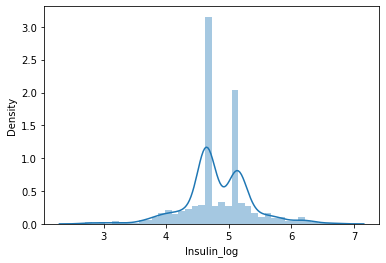

In [18]:
# Insulin_nan을 로그변환한다.
df["Insulin_log"] = np.log(df["Insulin_nan"]+1)
sns.distplot(df["Insulin_log"])

### 파생변수 만들기

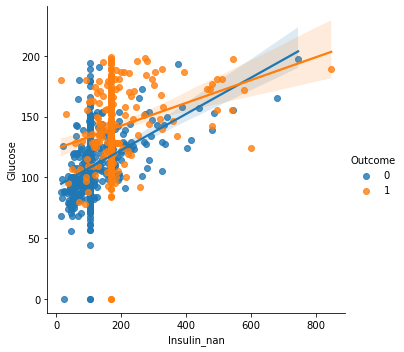

In [19]:
sns.lmplot(data=df, x="Insulin_nan", y="Glucose", hue="Outcome" )

* Glucose가 100보다 작은 값에서 발병률이 낮은 것으로 보인다.

In [20]:
df["low_glu_insulin"] = (df["Glucose"] < 100) & (df["Insulin_nan"] <= 102.5)
df["low_glu_insulin"].head()

0    False
1     True
2    False
3     True
4    False
Name: low_glu_insulin, dtype: bool

In [21]:
# crosstab(): 범주형 값에 대한 crosstab을 보여준다.
pd.crosstab(df["Outcome"], df["low_glu_insulin"])

low_glu_insulin,False,True
Outcome,,
0,332,168
1,263,5


* Glucose와 Insulin이 모두 낮을 때는 발병률이 낮다.

### 이상치(outlier) 다루기

E:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Insulin'>

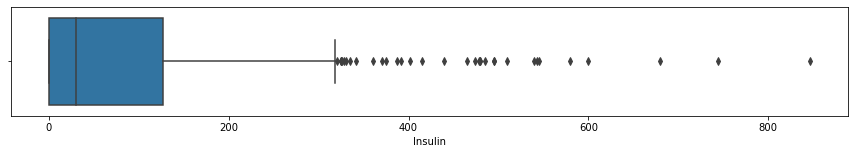

In [22]:
plt.figure(figsize=(15,2))
sns.boxplot(df["Insulin"])

In [23]:
df["Insulin_nan"].describe()

count    768.000000
mean     141.753906
std       89.100847
min       14.000000
25%      102.500000
50%      102.500000
75%      169.500000
max      846.000000
Name: Insulin_nan, dtype: float64

* 중앙값으로 Nan을 대체했기 때문에 Q1 값도 102.5이다.

In [24]:
# IQR 값 구하기
IQR3 = df["Insulin_nan"].quantile(0.75)
IQR1 = df["Insulin_nan"].quantile(0.25)
IQR = IQR3 - IQR1
IQR

67.0

In [25]:
# 이상치 찾기
OUT = IQR3 + (IQR * 1.5)
OUT

270.0

In [26]:
df[df["Insulin_nan"] > OUT].shape

(51, 16)

In [27]:
# 51개의 데이터를 제거하는 것은 너무 많으므로, 600 이상의 값만 제거한다.
df[df["Insulin_nan"] > 600].shape

(3, 16)

### Scaling
* https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df[["Glucose", "DiabetesPedigreeFunction"]])
scale = scaler.transform(df[["Glucose", "DiabetesPedigreeFunction"]])
scale

array([[ 0.84832379,  0.46849198],
       [-1.12339636, -0.36506078],
       [ 1.94372388,  0.60439732],
       ...,
       [ 0.00330087, -0.68519336],
       [ 0.1597866 , -0.37110101],
       [-0.8730192 , -0.47378505]])

In [29]:
df[["Glucose", "DiabetesPedigreeFunction"]] = scale
df[["Glucose", "DiabetesPedigreeFunction"]].head()

,Glucose,DiabetesPedigreeFunction
0,0.848324,0.468492
1,-1.123396,-0.365061
2,1.943724,0.604397
3,-0.998208,-0.920763
4,0.504055,5.484909


array([[<AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>]],
      dtype=object)

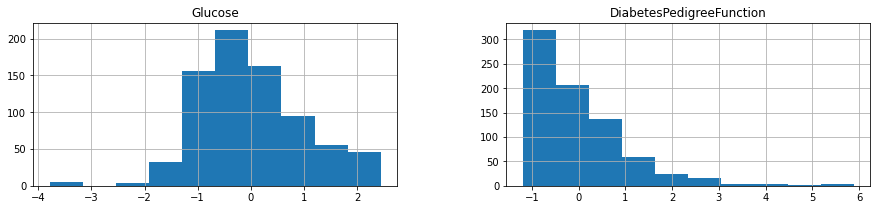

In [31]:
df[["Glucose", "DiabetesPedigreeFunction"]].hist(figsize=(15, 3))

* 값의 scale의 차이가 줄어들었다.

## 학습, 예측 데이터셋 나누기

In [32]:
# 8:2 의 비율로 구하기 위해 전체 데이터의 행에서 80% 위치에 해당되는 값을 구해서 split_count 라는 변수에 담습니다.
split_count = int(df.shape[0] * 0.8)
split_count

614

In [33]:
# train, test로 슬라이싱을 통해 데이터를 나눕니다.
train = df[:split_count].copy()
train.shape

(614, 16)

* 이상치를 제거할 때는 train 데이터에서만 제거한다. test는 예측할 데이터이므로 미래의 데이터는 제거해볼 수 없기 때문이다.

In [34]:
train = train[train["Insulin_nan"] < 600]
train.shape

(610, 16)

In [35]:
test = df[split_count:].copy()
test.shape

(154, 16)

## 학습, 예측에 사용할 컬럼

In [36]:
# feature_names 라는 변수에 학습과 예측에 사용할 컬럼명을 가져옵니다.
feature_names = train.columns.tolist()
feature_names.remove("Pregnancies")
feature_names.remove("Age_low")
feature_names.remove("Age_middle")
feature_names.remove("Age_high")
feature_names.remove("Insulin")
feature_names.remove("Insulin_log")
feature_names.remove("Outcome")
feature_names

['Glucose',
 'BloodPressure',
 'SkinThickness',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Pregnancies_high',
 'Insulin_nan',
 'low_glu_insulin']

## 정답값이자 예측해야 될 값

In [37]:
# label_name 이라는 변수에 예측할 컬럼의 이름을 담습니다.
label_name = "Outcome"
label_name

'Outcome'

## 학습, 예측 데이터셋 만들기

In [38]:
# 학습 세트 만들기 예) 시험의 기출문제
X_train = train[feature_names]
print(X_train.shape)
X_train.head()

(610, 9)


,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Pregnancies_high,Insulin_nan,low_glu_insulin
0,0.848324,72,35,33.6,0.468492,50,False,169.5,False
1,-1.123396,66,29,26.6,-0.365061,31,False,102.5,True
2,1.943724,64,0,23.3,0.604397,32,True,169.5,False
3,-0.998208,66,23,28.1,-0.920763,21,False,94.0,True
4,0.504055,40,35,43.1,5.484909,33,False,168.0,False


In [39]:
# 정답 값을 만들어 줍니다. 예) 기출문제의 정답
y_train = train[label_name]
print(y_train.shape)
y_train.head()

(610,)


0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [40]:
# 예측에 사용할 데이터세트를 만듭니다. 예) 실전 시험 문제
X_test = test[feature_names]
print(X_test.shape)
X_test.head()

(154, 9)


,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Pregnancies_high,Insulin_nan,low_glu_insulin
614,0.535352,74,26,36.1,0.257084,50,True,144.0,False
615,-0.466156,72,0,25.8,-0.799958,27,False,102.5,False
616,-0.121888,96,0,28.7,-0.950964,30,False,102.5,False
617,-1.655448,62,13,20.1,-0.648952,23,False,15.0,True
618,-0.278373,82,24,28.2,2.446670,50,True,169.5,False


In [41]:
# 예측의 정답값 예) 실전 시험 문제의 정답
y_test = test[label_name]
print(y_test.shape)
y_test.head()

(154,)


614    1
615    0
616    0
617    0
618    1
Name: Outcome, dtype: int64

## 머신러닝 알고리즘 가져오기

In [42]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model

DecisionTreeClassifier()

## 학습(훈련)
* 시험을 볼 때 기출문제(X_train)와 정답(y_train)을 보고 공부하는 과정과 유사합니다.

In [43]:
# 결측치가 들어있으면 에러가 발생한다.
model.fit(X=X_train, y=y_train)

DecisionTreeClassifier()

## 예측
* 실전 시험문제(X_test)라고 보면 됩니다. 우리가 정답을 직접 예측합니다.

In [44]:
y_predict = model.predict(X_test)
y_predict[:5]

array([1, 0, 0, 0, 1], dtype=int64)

## 트리 알고리즘 분석하기
* 의사결정나무를 시각화 합니다.

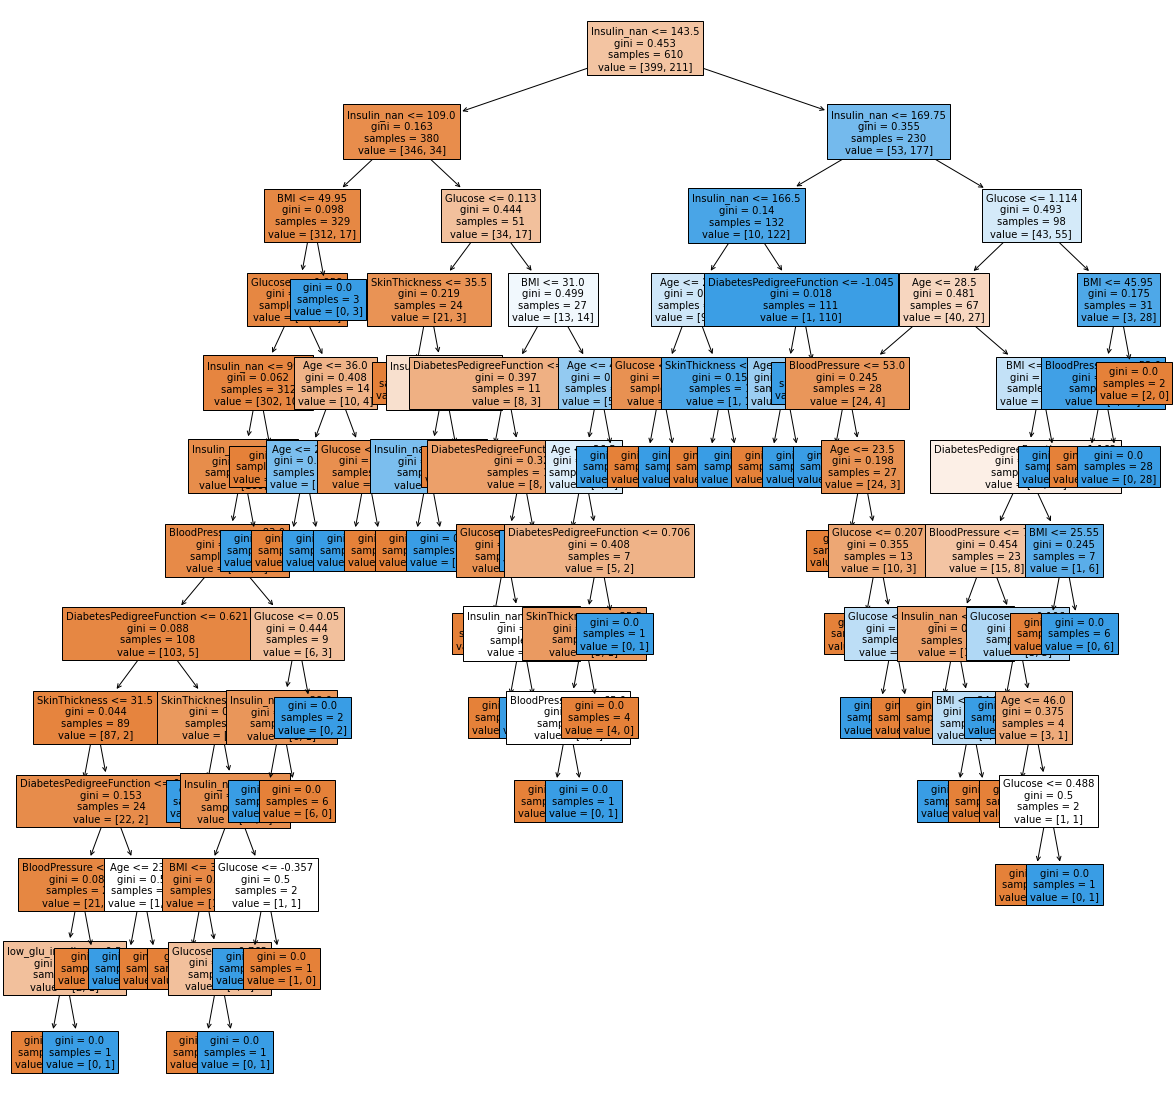

In [45]:
# gini계수가 0이 되면 트리를 그리기를 멈추고 당뇨병 여부를 판단
from sklearn.tree import plot_tree

plt.figure(figsize=(20,20))
tree = plot_tree(model,
                 feature_names=feature_names,
                 filled=True,
                 fontsize=10)

* Insulin_nan이 가장 위에 있다.

In [46]:
# graphviz 를 통해 시각화 합니다.
# graphviz 는 별도의 설치가 필요합니다. 
# graphviz 와 파이썬에서 graphviz 를 사용할 수 있게 해주는 도구 2가지를 설치해 주셔야 합니다.
# import graphviz
# from sklearn.tree import export_graphviz

# dot_tree = export_graphviz(model,
#                            feature_names = feature_names,
#                            filled=True)
# graphviz.Source(dot_tree)

In [47]:
# 피처의 중요도를 추출하기
model.feature_importances_

array([0.11993864, 0.03001248, 0.02196124, 0.0716271 , 0.03094277,
       0.08936688, 0.        , 0.63132048, 0.0048304 ])

<AxesSubplot:>

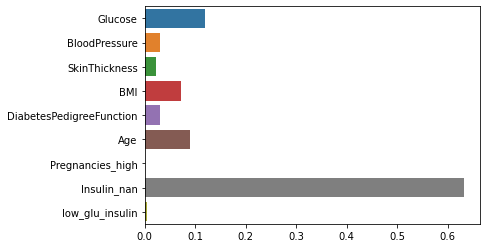

In [48]:
# 피처의 중요도 시각화 하기
sns.barplot(x=model.feature_importances_, y=feature_names)

* 이전에는 Pregnancies가 꽤 중요한 역할을 했으나, Pregnancies_high는 그다지 중요한 역할을 하지 않는 것으로 보인다.
* Insulin_nan의 중요성이 매우 크다.
* low_glu_insulin이 크게 영향을 미치지는 않아 보인다.

## 정확도(Accuracy) 측정하기

In [49]:
# 실제값 - 예측값을 빼주면 같은 값은 0으로 나오게 됩니다. 
# 여기에서 절대값을 씌운 값이 1인 값이 다르게 예측한 값이 됩니다.
# 합하면 다르게 예측한 값의 개수
diff_count = abs(y_test - y_predict).sum()
diff_count

18

* 38 => 37(임신횟수) => 48(나이) => 24(인슐린 결측치를 평균으로 대체) => 19(인슐린 결측치를 중앙값으로 대체) => 20(인슐린에 로그변환) => 18(글루코스와 인슐린의 상관계수로 파생변수 생성) => 16(인슐린 600 이상의 이상치를 제거) => 18(스케일링)

In [50]:
# 예측의 정확도를 구합니다. 100점 만점 중에 몇 점을 맞았는지 구한다고 보면 됩니다.
(len(y_test) - diff_count) / len(y_test) * 100

88.31168831168831

In [51]:
# 위에서 처럼 직접 구할 수도 있지만 미리 구현된 알고리즘을 가져와 사용합니다.
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_predict) * 100

88.31168831168831

In [52]:
# model 의 score 로 점수를 계산합니다.
model.score(X_test, y_test) * 100

88.31168831168831